In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
import json

# Load data

In [2]:
adapters = {'name': 'adapters_anomaly_injected', 'df': pd.read_csv('data/adapters_anomaly_injected.csv')}
brockers = {'name': 'brokers_anomaly_injected', 'df': pd.read_csv('data/brokers_anomaly_injected.csv')}
callbrocker = {'name': 'callbrocker', 'df': pd.read_csv('data/callbroker.csv')}
chatbrocker = {'name': 'chatbrocker', 'df': pd.read_csv('data/chatbroker.csv')}
combined_logs = {'name': 'combined_logs', 'df': pd.read_csv('data/combined_logs.csv')}
error_samples = {'name': 'error_samples', 'df': pd.read_csv('data/error_samples.csv')}
restamqpgw = {'name': 'restamqpgw_anomaly_injected', 'df': pd.read_csv('data/restamqpgw_anomaly_injected.csv')}
smsbrocker = {'name': 'smsbrocker', 'df': pd.read_csv('data/smsbroker.csv')}

# Basic properties of dataframes

In [3]:
def get_stat_str(log_dict):
    n_u = len(log_dict['df'].drop_duplicates())
    ldf = len(log_dict['df'])
    return f"{log_dict['name']}:\trows = {ldf} (dups: {ldf - n_u}, unique: {100*n_u/ldf: 2.1f}%)\t" \
        f"cols[{len(log_dict['df'].columns)}]=\t{log_dict['df'].columns.tolist()}"

print("Basic statistics on dataframes:\n")
print(f"{get_stat_str(adapters)}\n")
print(f"{get_stat_str(brockers)}\n")
print(f"{get_stat_str(callbrocker)}\n")
print(f"{get_stat_str(chatbrocker)}\n")
print(f"{get_stat_str(combined_logs)}\n")
print(f"{get_stat_str(error_samples)}\n")
print(f"{get_stat_str(restamqpgw)}\n")
print(f"{get_stat_str(smsbrocker)}\n")

Basic statistics on dataframes:

adapters_anomaly_injected:	rows = 24164 (dups: 345, unique:  98.6%)	cols[16]=	['version', 'messageRealm', 'serviceAction', 'messageParams.subscriber', 'messageParams.calledMessageQueue', 'messageParams.type', 'messageParams.messageID', 'messageParams.correlationID', 'messageParams.transactionID', 'messageParams.originatingMS', 'messageParams.terminatingMS', 'serviceData.httpParams.statusCode', 'message_id_length', 'correlation_id_length', 'transaction_id_length', 'anomaly']

brokers_anomaly_injected:	rows = 42129 (dups: 1024, unique:  97.6%)	cols[16]=	['version', 'messageRealm', 'serviceAction', 'messageParams.subscriber', 'messageParams.calledMessageQueue', 'messageParams.type', 'messageParams.messageID', 'messageParams.correlationID', 'messageParams.transactionID', 'messageParams.originatingMS', 'messageParams.terminatingMS', 'serviceData.httpParams.statusCode', 'message_id_length', 'correlation_id_length', 'transaction_id_length', 'anomaly']

callbro

Conclusions #1:
* Data has 2 formats
* Data in one format has up to 3% of duplicate rows, data in the other format has no duplicates

In [4]:
# logs are sorted by length decrease
logs_format1 = [brockers, adapters, restamqpgw]
logs_format2 = [combined_logs, callbrocker, error_samples, chatbrocker, smsbrocker]
assert len(logs_format1) + len(logs_format2) == 8
assert all([len(df1['df']) >= len(df2['df']) for df1, df2 in zip(logs_format1[:-1], logs_format1[1:])])
assert all([len(df1['df']) >= len(df2['df']) for df1, df2 in zip(logs_format2[:-1], logs_format2[1:])])

In [5]:
def check_if_subset(parent_dict_candidates, child_dict_candidates):
    merged_df = None
    test_parent_df = None
    test_child_df = None
    duplicates_dropped = None
    for parent_dict in parent_dict_candidates:
        for child_dict in child_dict_candidates:
            if set(parent_dict['df'].columns.tolist()) != set(child_dict['df'].columns.tolist()):
                assert f"Columns in {parent_dict['name']} and {child_dict['name']} are different"
            else:
                print("Checking...")
            duplicates_dropped = False
            if parent_dict['df'].duplicated(keep=False).any():
                test_parent_df = parent_dict['df'].drop_duplicates()
                duplicates_dropped = True
            else:
                test_parent_df = parent_dict['df']
            if child_dict['df'].duplicated(keep=False).any():
                test_child_df = child_dict['df'].drop_duplicates()
                duplicates_dropped = True
            else:
                test_child_df = child_dict['df']
            merged_df = test_parent_df.merge(test_child_df)

            if len(merged_df) == len(test_parent_df):
                print(f"dataframe {child_dict['name']} is subset of dataframe {parent_dict['name']} ({duplicates_dropped = })")
    del parent_dict, child_dict, merged_df, test_parent_df, test_child_df, duplicates_dropped

check_if_subset([logs_format1[0]], logs_format1[1:])
check_if_subset([logs_format1[1]], logs_format1[2:])
assert len(logs_format1) == 3

check_if_subset([logs_format2[0]], logs_format2[1:])
check_if_subset([logs_format2[1]], logs_format2[2:])
check_if_subset([logs_format2[2]], logs_format2[3:])
check_if_subset([logs_format2[3]], logs_format2[4:])
assert len(logs_format2) == 5

Checking...
Checking...
Checking...
Checking...
Checking...
Checking...
Checking...
Checking...
Checking...
Checking...
Checking...
Checking...
Checking...


Conclusions #2:
* There are no simple subsets in any of the analyzed dataframes

In [6]:
def get_col_str(df, col):
    vc_s = df[col].value_counts()
    res = f"{col}: {len(vc_s)} values"
    if len(vc_s) <= 3:
        res += f" {vc_s.to_dict()}"
    else:
        res += f" (top_values: {vc_s.iloc[:3].to_dict()})"
    return res

for log_dict in logs_format1:
    print(f"{log_dict['name']} ({len(log_dict['df'])} rows)")
    for col in sorted(log_dict['df'].columns.tolist()):
        print(f"\t{get_col_str(log_dict['df'], col)}")
    print()

for log_dict in logs_format2:
    print(f"{log_dict['name']} ({len(log_dict['df'])} rows)")
    for col in sorted(log_dict['df'].columns.tolist()):
        print(f"\t{get_col_str(log_dict['df'], col)}")
    print()

brokers_anomaly_injected (42129 rows)
	anomaly: 2 values {'no': 31033, 'yes': 11096}
	correlation_id_length: 2 values {32: 38858, 24: 3271}
	messageParams.calledMessageQueue: 28 values (top_values: {'notificationbroker-notificationbroker-b6775b9dc-6jsj9': 8991, 'callbroker-callbroker-74686c56b-kz9c9': 7128, 'restamqpgw-restamqpgw-5d45c8c667-dq2b9': 3290})
	messageParams.correlationID: 7770 values (top_values: {'0': 15448, '5907e0106fe74d715702e3fceef7dab7': 16, '05e4cde09ee21546f7d4c5aff9c08af7': 14})
	messageParams.messageID: 40358 values (top_values: {'158af430-019d-4797-bfd7-5954a336bfd0': 3, 'c7eaf9fa-4474-4700-864b-2f3301ed3a1a': 2, '1ec12f65-257f-4db0-8850-6f056d27ca67': 2})
	messageParams.originatingMS: 17 values (top_values: {'notificationbroker': 9024, 'callbroker': 7128, 'chatbroker': 5992})
	messageParams.subscriber: 40 values (top_values: {'BONECB1i6xD7piqH': 17593, 'Qnz6UYeVWidlVh1o': 12932, 'j5fYLPEFeXN4aiJY': 4286})
	messageParams.terminatingMS: 17 values (top_values: {'

Conclusions #3:
* All data types in all formats look categorical, there are no numerical values
    * We can't use algorithms like Isolation Forest here, because they work with continuous data on input
    * 'anomaly' column also has only 2 values, so it is not "anomaly detection", but classification problem
* The following columns can be safely deleted
    * Format 1: 'version'
    * Format 2: '_id', '_index', '_score', '_type'
* There is column 'messageParams.messageID' for **format 1**, which is different for 90+% of data. Probably it can be interesting exclusions from the normal message flow, but it can't be seriously connected to the labaled anomalies, because amount of rows is different by 10+ times.
* There is about 50% of duplicate messages for 'messageParams.transactionID' column for **format 1**
* There is column 'Message' for **format 2**, which contain hierarchical data => **it looks that it can be converted to the format 1!**

In [7]:
# dropping columns with constant values
for log_dict in logs_format1:
    log_dict['df'].drop(columns=['version'], inplace=True)
for log_dict in logs_format2:
    log_dict['df'].drop(columns=['_id', '_index', '_score', '_type'], inplace=True)

# Try to convert all data to the same format

In [8]:
# Naive way does not work, as logs contain a lot of general messages
# converted_all_logs = pd.json_normalize(logs_format2[0]['df']['Message'].tolist())

In [9]:
heads_json = [
    ' Message is: {',
    ' Message to deliver: {',
]
# Logs, which starts from this message contain corrupted JSON, so it is not very clear how to parse it
heads_ignore = [
    ' Message successfully persisted: {',
]

format1_cols = logs_format1[0]['df'].columns.tolist()

for log_dict in logs_format2:
    name = log_dict['name']

    msg_list = []
    for msg in log_dict['df']['Message'].tolist():
        ignore_flag = False
        for head in heads_ignore:
            if msg.startswith(head):
                ignore_flag = True
                break
        if ignore_flag:
            continue
        found_flag = False
        for head in heads_json:
            if msg.startswith(head):
                msg = msg[len(head) - 1:].strip()
                found_flag = True
                break
        if not found_flag:
#             print(f"not parsed: {msg}")
            continue
        try:
            msg_list.append(json.loads(msg))
        except ValueError as e:
            print(f"Not valid msg: {msg}")
            break
    converted_df = pd.json_normalize(msg_list)
    del msg_list
    print(f"{name}: collected {len(converted_df)} rows, {len(converted_df.columns)} columns")

    # restore initial columns
    converted_df.drop(columns=converted_df.columns.difference(format1_cols), inplace=True)
#     converted_df['anomaly'] - no information
    converted_df['correlation_id_length'] = converted_df['messageParams.correlationID'].str.len()
    converted_df['message_id_length'] = converted_df['messageParams.messageID'].str.len()
    converted_df['transaction_id_length'] = converted_df['messageParams.transactionID'].str.len()
#     converted_df['version'] - no information

    if len(converted_df) != len(converted_df.drop_duplicates()):
        print(f"\tFYI: {name} contain duplicates")

    print(f"\tThe following {len(converted_df.columns)} columns filled: {converted_df.columns.tolist()}\n")

combined_logs: collected 928 rows, 58 columns
	The following 14 columns filled: ['messageRealm', 'serviceAction', 'messageParams.subscriber', 'messageParams.calledMessageQueue', 'messageParams.type', 'messageParams.messageID', 'messageParams.correlationID', 'messageParams.transactionID', 'messageParams.originatingMS', 'messageParams.terminatingMS', 'serviceData.httpParams.statusCode', 'correlation_id_length', 'message_id_length', 'transaction_id_length']

callbrocker: collected 630 rows, 49 columns
	The following 14 columns filled: ['messageRealm', 'serviceAction', 'messageParams.subscriber', 'messageParams.calledMessageQueue', 'messageParams.type', 'messageParams.messageID', 'messageParams.correlationID', 'messageParams.transactionID', 'messageParams.originatingMS', 'messageParams.terminatingMS', 'serviceData.httpParams.statusCode', 'correlation_id_length', 'message_id_length', 'transaction_id_length']

error_samples: collected 68 rows, 52 columns
	The following 14 columns filled: ['m

Conclusion #4:
* Logs in **format 2** can be converted to **format 1**, but without information about "anomaly" and "version"
* Since some log messages are corrupted, probably a number of lines is missed

# Analyze Format 1 in more details

## Check correlation for categorical variables to find model inputs

In [10]:
for log_dict in logs_format1:
    print(f"{log_dict['name']}\n")
    print(f"{pd.crosstab(index=log_dict['df']['anomaly'], columns=log_dict['df']['correlation_id_length'])}\n")
    print(f"{pd.crosstab(index=log_dict['df']['anomaly'], columns=log_dict['df']['message_id_length'])}\n")
    print(f"{pd.crosstab(index=log_dict['df']['message_id_length'], columns=log_dict['df']['correlation_id_length'])}\n")
    print("\n")

brokers_anomaly_injected

correlation_id_length    24     32
anomaly                           
no                        0  31033
yes                    3271   7825

message_id_length    16     36
anomaly                       
no                    0  31033
yes                3290   7806

correlation_id_length    24     32
message_id_length                 
16                      281   3009
36                     2990  35849



adapters_anomaly_injected

correlation_id_length    24     32
anomaly                           
no                        0  17707
yes                    1831   4626

message_id_length    16     36
anomaly                       
no                    0  17707
yes                1815   4642

correlation_id_length    24     32
message_id_length                 
16                      183   1632
36                     1648  20701



restamqpgw_anomaly_injected

correlation_id_length   24    32
anomaly                         
no                       0  8998
y

In [11]:
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
# https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * ( r - 1)) / (n - 1))    
    rcorr = r - ((r - 1)**2)/(n - 1)
    kcorr = k - ((k - 1)**2)/(n - 1)
    return np.sqrt(phi2corr / min( (kcorr - 1), (rcorr - 1)))

for log_dict in logs_format1:
    print(f"{log_dict['name']}\n")
    corr_list = []

    cols = log_dict['df'].columns.to_list()
    cols.remove('messageParams.messageID')
    cols.remove('messageParams.transactionID')

    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            conf_matrix = pd.crosstab(log_dict['df'][cols[i]], log_dict['df'][cols[j]]).to_numpy()
            corr = cramers_corrected_stat(conf_matrix)
            print(f"{cols[i]} <-> {cols[j]}: {corr}")
            if (cols[i] == 'anomaly') or (cols[j] == 'anomaly'):
                corr_list.append((f"{cols[i]} <-> {cols[j]}", corr))
    print()
    corr_list.sort(key=lambda x: x[1])
    print("Best correlations with anomaly:")
    for (label, corr) in corr_list:
        if corr > 0.2:
            print(f"\t{label}: {corr}")
    print()

brokers_anomaly_injected

messageRealm <-> serviceAction: 0.8611058107414078
messageRealm <-> messageParams.subscriber: 0.16857632360567526
messageRealm <-> messageParams.calledMessageQueue: 0.7091474390806591
messageRealm <-> messageParams.type: 0.2989410449670067
messageRealm <-> messageParams.correlationID: 0.715517927958942
messageRealm <-> messageParams.originatingMS: 0.7090108662136831
messageRealm <-> messageParams.terminatingMS: 0.49583597321742295
messageRealm <-> serviceData.httpParams.statusCode: 0.24260973058668953
messageRealm <-> message_id_length: 0.02267334821466676
messageRealm <-> correlation_id_length: 0.029366864712070558
messageRealm <-> transaction_id_length: 0.025033650662911928
messageRealm <-> anomaly: 0.010049014792927342
serviceAction <-> messageParams.subscriber: 0.26795756305686824
serviceAction <-> messageParams.calledMessageQueue: 0.5135808029946223
serviceAction <-> messageParams.type: 0.5852147190243996
serviceAction <-> messageParams.correlationID: 0.4

messageParams.type <-> messageParams.correlationID: 0.0
messageParams.type <-> messageParams.originatingMS: 0.5665457620976878
messageParams.type <-> messageParams.terminatingMS: 0.6089298037338695
messageParams.type <-> serviceData.httpParams.statusCode: 0.4862479137989089
messageParams.type <-> message_id_length: 0.11687023174872915
messageParams.type <-> correlation_id_length: 0.11655557027847183
messageParams.type <-> transaction_id_length: 0.11672775605980265
messageParams.type <-> anomaly: 0.027902036480713724
messageParams.correlationID <-> messageParams.originatingMS: 0.3463468804203448
messageParams.correlationID <-> messageParams.terminatingMS: 0.3403615193163084
messageParams.correlationID <-> serviceData.httpParams.statusCode: 0.08751930227092714
messageParams.correlationID <-> message_id_length: 0.05340034946055303
messageParams.correlationID <-> correlation_id_length: 0.0
messageParams.correlationID <-> transaction_id_length: 0.009674678794788213
messageParams.correlation

Conclusions #5:
* The following features have good correlation with target: 'message_id_length' (2 values), 'correlation_id_length' (2 values), 'transaction_id_length' (2 values), 'serviceData.httpParams.statusCode' (14 values)

## Training

### Select Data for Training

In [12]:
for log_dict in logs_format1:
    cols = [
        'message_id_length',
        'correlation_id_length',
        'transaction_id_length',
        'serviceData.httpParams.statusCode',
    ]
    X = pd.concat([pd.get_dummies(log_dict['df'][col], dtype=int) for col in cols], axis='columns').to_numpy()
    y = log_dict['df']['anomaly'].apply(lambda x: 0 if x == 'no' else 1).to_numpy().T
    log_dict['X'] = X
    log_dict['y'] = y

### Split Train and Test

brokers_anomaly_injected
	Minimal random forest: 0.9971948500323671
	Decision tree: 1.0


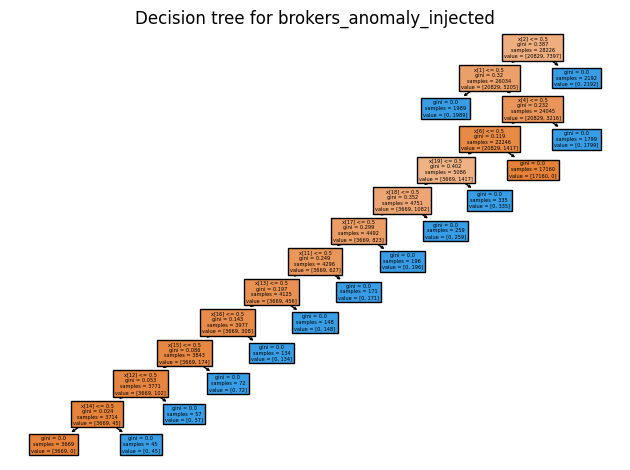

adapters_anomaly_injected
	Minimal random forest: 0.9894670846394984
	Decision tree: 1.0


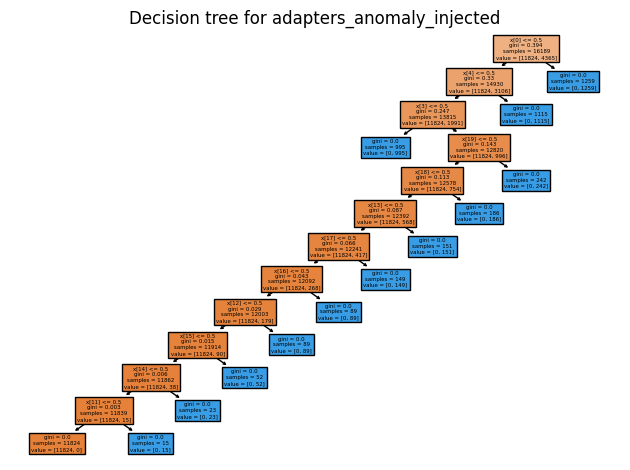

restamqpgw_anomaly_injected
	Minimal random forest: 0.9935483870967742
	Decision tree: 1.0


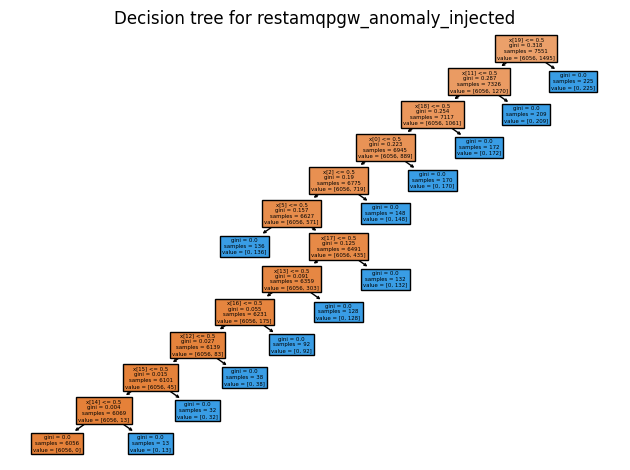

In [13]:
for log_dict in logs_format1:
    print(log_dict['name'])
    X_train, X_test, y_train, y_test = train_test_split(
        log_dict['X'], log_dict['y'], test_size=0.33, random_state=0,
    )
    clf = RandomForestClassifier(n_estimators=2, max_depth=10, random_state=0)
    clf.fit(X_train, y_train)
    print(f"\tMinimal random forest: {clf.score(X_test, y_test)}")
    clf = DecisionTreeClassifier(random_state=0, max_depth=15)
    clf.fit(X_train, y_train)
    print(f"\tDecision tree: {clf.score(X_test, y_test)}")

    plt.figure()
    plot_tree(clf, filled=True)
    plt.title(f"Decision tree for {log_dict['name']}")
    plt.tight_layout()
    plt.show()

In [14]:
cols = [
    'message_id_length',                 #0-1
    'correlation_id_length',             #2-3
    'transaction_id_length',             #4-5
    'serviceData.httpParams.statusCode', #6-20
]
for col in cols:
    print(f"{pd.concat([log_dict['df'][col] for log_dict in logs_format1], axis='index').value_counts()}\n")

message_id_length
36    72207
16     5357
Name: count, dtype: int64

correlation_id_length
32    72221
24     5343
Name: count, dtype: int64

transaction_id_length
36    72176
30     5388
Name: count, dtype: int64

serviceData.httpParams.statusCode
0.0      57730
200.0     8192
201.0     3948
204.0     2337
503.0     1220
502.0      943
500.0      676
403.0      645
400.0      568
429.0      499
401.0      292
408.0      227
202.0      151
404.0      123
303.0       13
Name: count, dtype: int64



In [15]:
for log_dict in logs_format1:
    print(log_dict['name'])
#     df_train, df_test = train_test_split(
#         log_dict['df'], test_size=0.33, random_state=0,
#     )
    df_test = log_dict['df']
    pred_y = []
    for row in df_test.itertuples(index=False):
        val = 1 if (
            row.message_id_length == 16 or
            row.correlation_id_length == 24 or
            row.transaction_id_length == 30 or
            # row._10 is "serviceData.httpParams.statusCode"
            row._10 not in [0, 200, 201, 202, 204, 303]
            ) else 0
        pred_y.append(val)
    pred_y = np.array(pred_y).T
    y_test = df_test['anomaly'].apply(lambda x: 0 if x == 'no' else 1).to_numpy().T
    print(f"\tAccuracy for analytical rule: {accuracy_score(y_test, pred_y)}")

brokers_anomaly_injected
	Accuracy for analytical rule: 1.0
adapters_anomaly_injected
	Accuracy for analytical rule: 1.0
restamqpgw_anomaly_injected
	Accuracy for analytical rule: 1.0
